# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

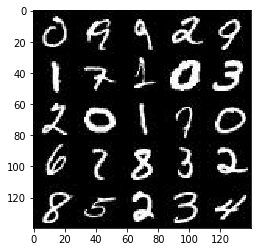

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

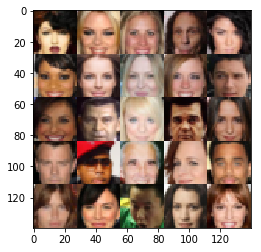

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=())
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha):
    return tf.maximum(x, alpha * x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    training = True
    alpha = 0.01
    drop_rate = 0.2

    def conv_layer(prev_layer, layer_depth, with_batch_normalization=True):
        layer = tf.layers.conv2d(prev_layer, layer_depth, kernel_size=5, strides=2, padding='same', use_bias=False, activation=None,
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=training)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("discriminator", reuse=reuse):
        layer = conv_layer(images, layer_depth=16, with_batch_normalization=False)
        layer_depths = [32, 64]
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)

        orig_shape = layer.get_shape().as_list()
        conv_layer = tf.reshape(layer, shape=(-1, orig_shape[1] * orig_shape[2] * orig_shape[3]))

        logits = tf.layers.dense(conv_layer, 1, activation=None)
        out = tf.nn.sigmoid(logits) 

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, drop_rate=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    def full_connected(pre_layer, num_units):
        layer = tf.layers.dense(pre_layer, num_units, use_bias=False, activation=None,
                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer
    
    def conv_layer(prev_layer, layer_depth, strides=2):
        layer = tf.layers.conv2d_transpose(prev_layer, layer_depth, kernel_size=5, strides=strides, padding='same', use_bias=False, activation=None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("generator", reuse=False if is_train==True else True):
        x = full_connected(z, 7*7*512)
        x = tf.reshape(x, shape=(-1, 7, 7, 512))

        layer_depths = [256, 128] # 14*14*256, 28*28*128
        layer = x
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)
        layer = conv_layer(layer, layer_depth=64, strides=1)

        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, kernel_size=5, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False, drop_rate=0.0),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=100
    n_sample_images = 25
    steps = 0
    losses = []
   
    batches, image_width, image_height, image_channels = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_sample_images, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0620... Generator Loss: 3.3724
Epoch 1/2... Discriminator Loss: 0.1488... Generator Loss: 2.1525
Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 3.6086
Epoch 1/2... Discriminator Loss: 0.0347... Generator Loss: 4.8344
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 2.7899
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.5134
Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 2.2163... Generator Loss: 0.2197
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.6167


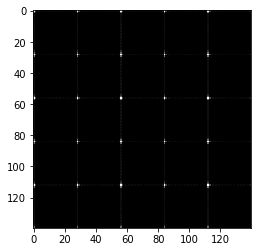

Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.6193... Generator Loss: 1.0358
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.9528... Generator Loss: 0.2191
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 0.5017
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.8164


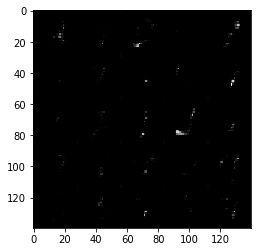

Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 1.5591... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.5351
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.6238... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 1.6578... Generator Loss: 0.3550


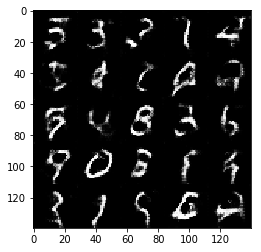

Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.5502... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.6454


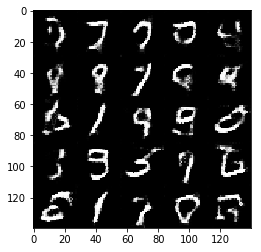

Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.5542... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.5921


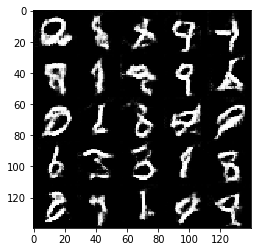

Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.2889
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.4577


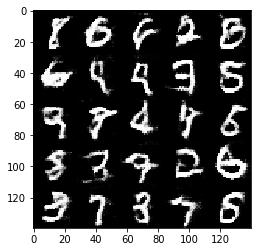

Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.4881
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.5392


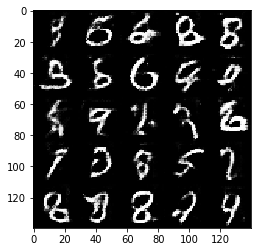

Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.6265... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.6411


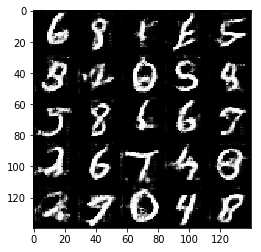

Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.7335... Generator Loss: 0.2942
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.4043


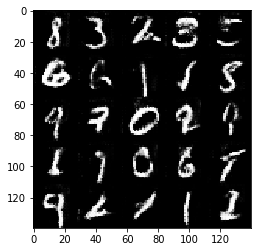

Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.6848... Generator Loss: 0.2628
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.6955
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 1.0060


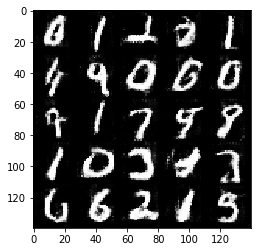

Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 0.3381
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.4102
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.4720
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.5622


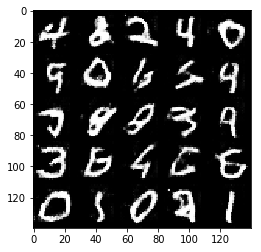

Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.5330
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.4376


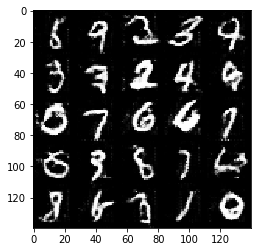

Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.6211


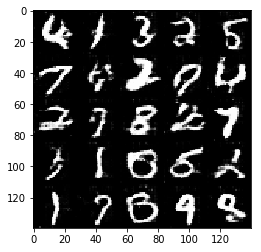

Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.5145
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.4515
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.5107
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.5240


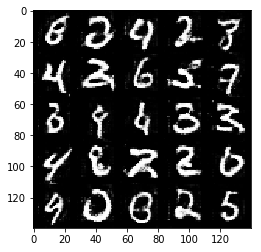

Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.7051


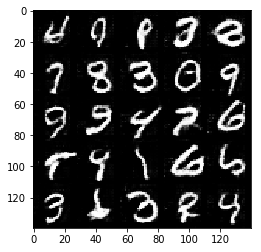

Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.5869... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.2881
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.4974
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.5831


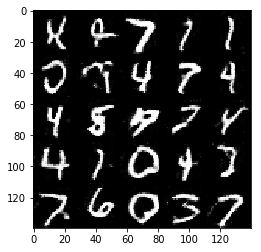

Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.4611
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.5630
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.4742
Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.5872


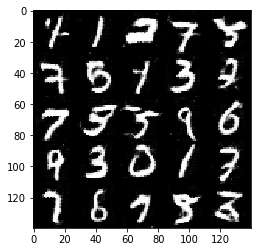

Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.6450
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.5303
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.5694


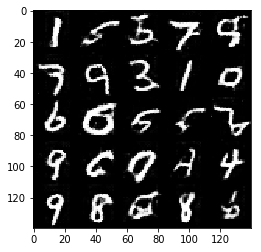

Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.5849


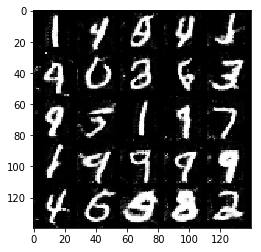

Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.4583
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.5044
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.7650
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6417


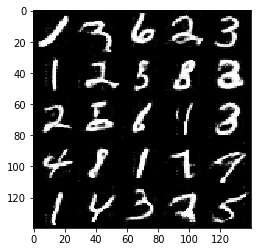

Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.4957


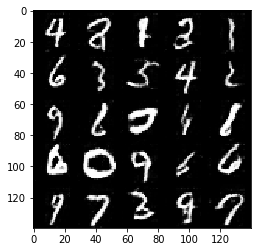

Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.3175... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.5821


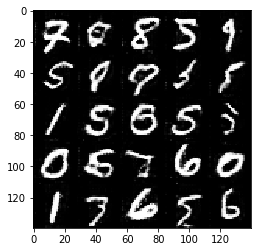

Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.4507
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.5329... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.6442


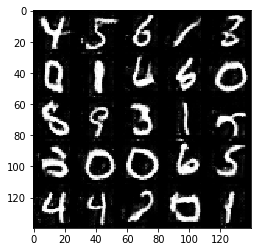

Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.4706
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.4463
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.5710


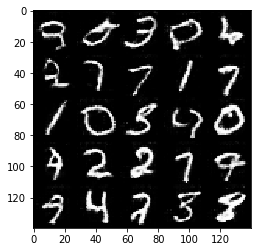

Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.4238
Epoch 2/2... Discriminator Loss: 1.1123... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 0.7256


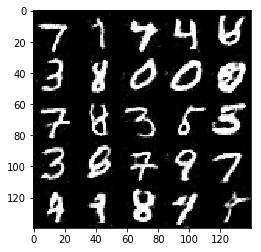

Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.4957
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.4938
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.5554


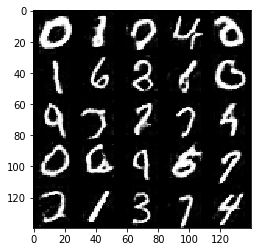

Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.6288
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.5500
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.5226
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.7179


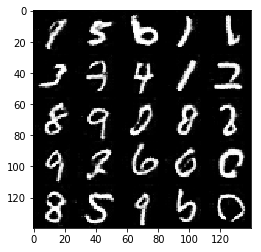

Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.5384
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.4712
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.5495
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.7687


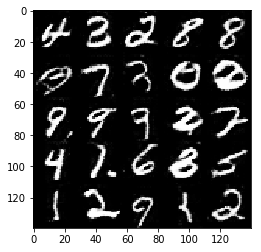

Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.5392
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.6512
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.5785


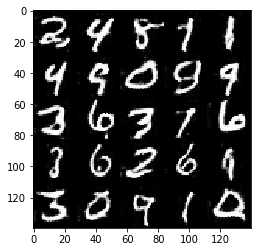

Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 0.4032
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.5985... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.5130
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.4711


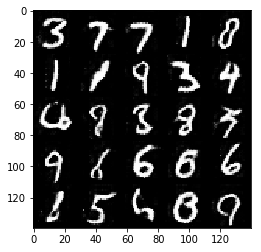

Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.4808
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.5625... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.5702


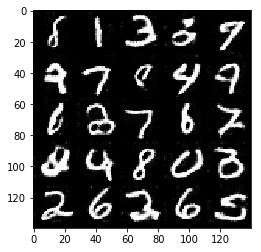

Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.4651... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.5028


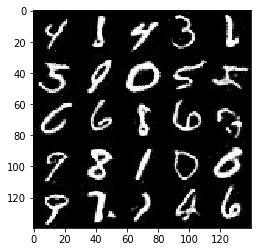

Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.5085
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 0.5083
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.5845
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.4767... Generator Loss: 0.4119


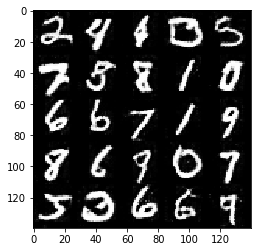

Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 0.4570
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.5320... Generator Loss: 0.5495
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.5159


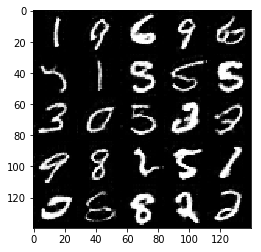

Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 1.4840... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.6833


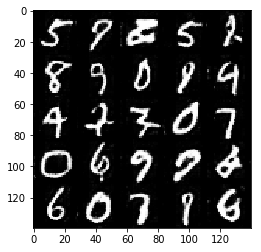

Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.5692
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.5776... Generator Loss: 0.3834
Epoch 2/2... Discriminator Loss: 1.4968... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 1.3636... Generator Loss: 0.6021


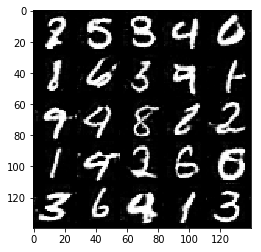

Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.5528
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.5339
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 0.5711


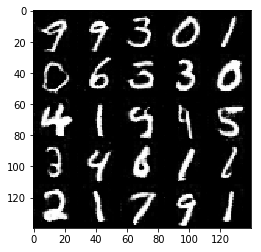

Epoch 2/2... Discriminator Loss: 1.4716... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 0.5806
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.7674


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 4.0019
Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 4.9820
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.7641


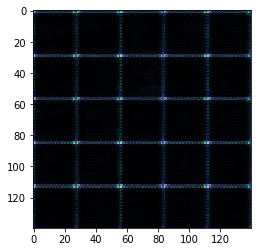

Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 1.6924... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.7840... Generator Loss: 0.4230


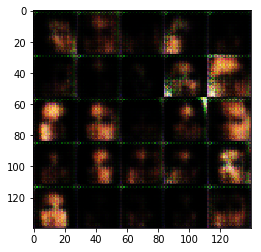

Epoch 1/1... Discriminator Loss: 1.7399... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.7718... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.4677


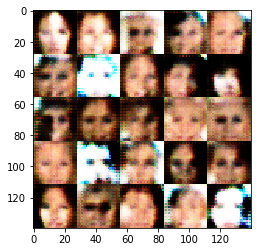

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.6882... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.5180


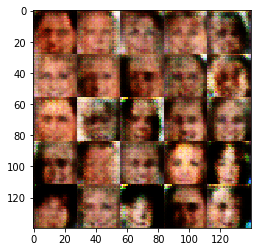

Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5775


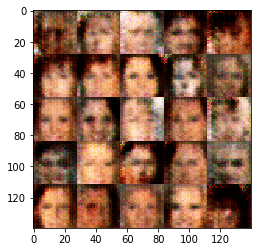

Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6356


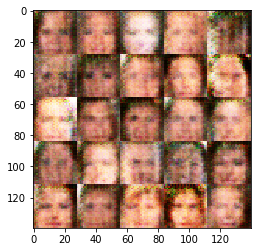

Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6393


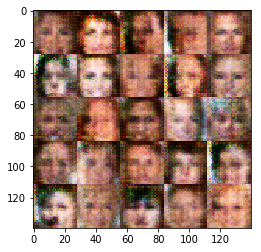

Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6684


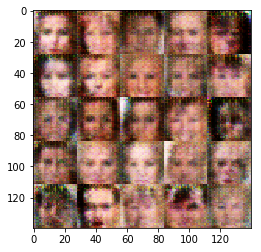

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6601


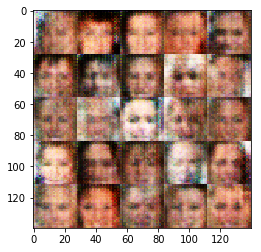

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6499


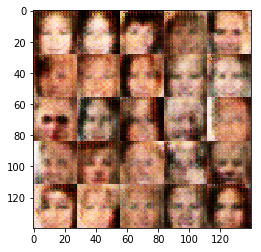

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6688


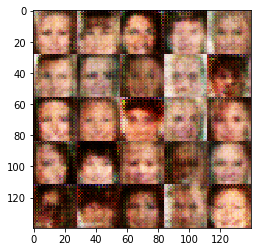

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6679


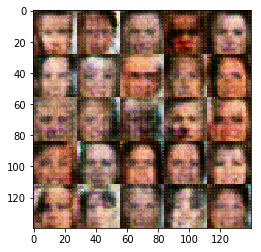

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6764


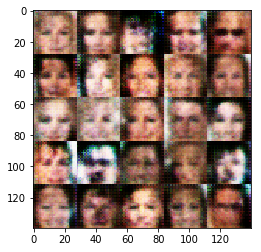

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6805


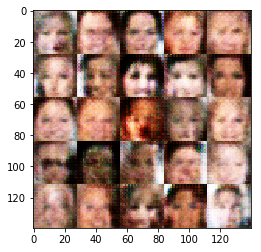

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6861


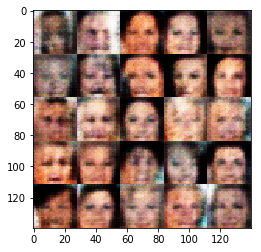

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6834


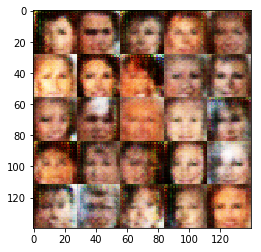

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6831


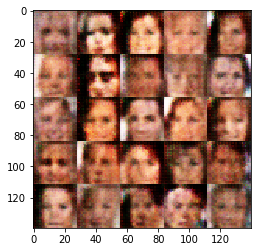

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6859


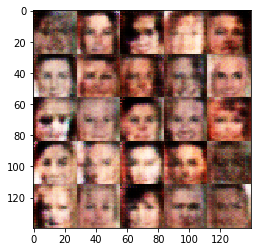

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6684


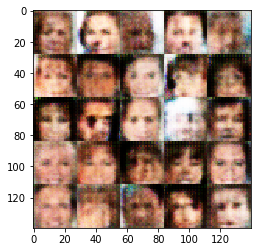

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6843


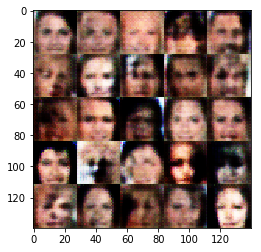

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6803


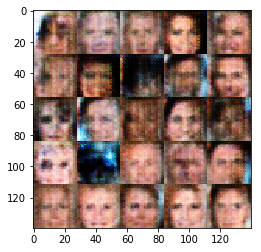

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6759


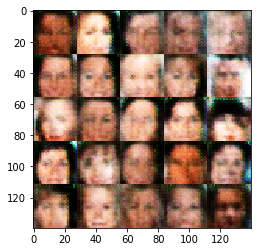

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6865


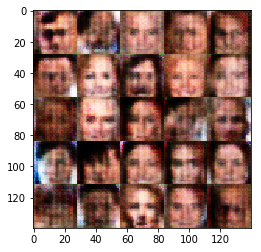

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6846


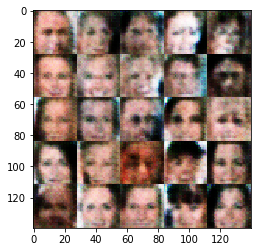

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7131


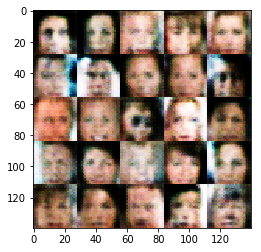

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6770


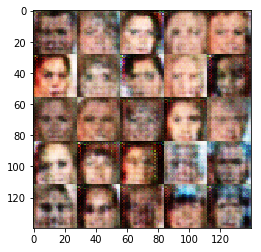

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6850


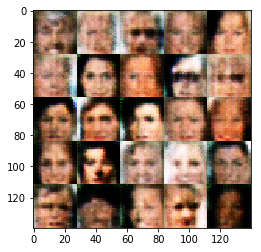

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6663


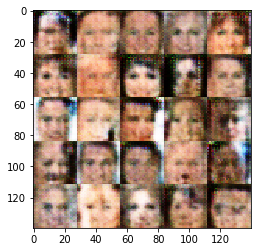

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6662


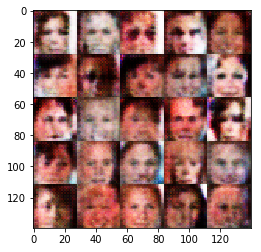

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6643


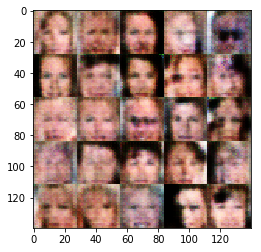

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6582


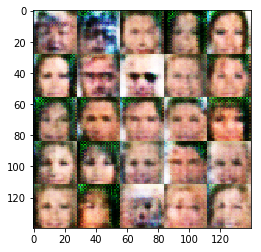

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6930


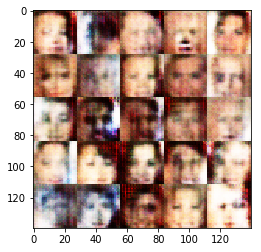

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6712


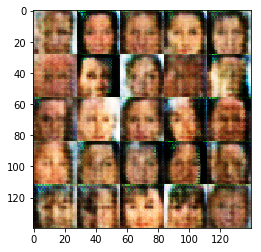

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6838


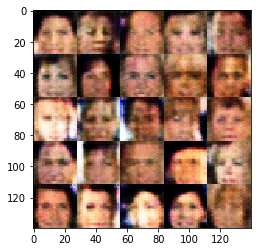

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6954


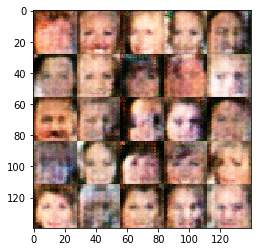

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6947


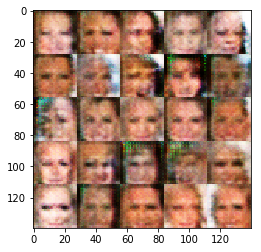

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6743


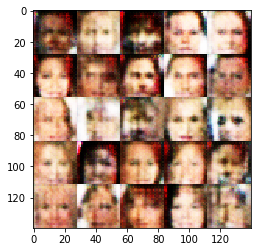

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7008


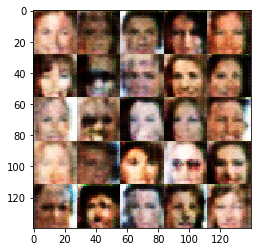

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6961


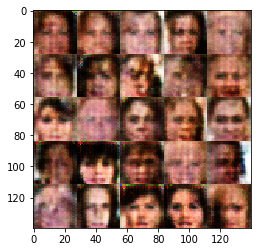

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6922


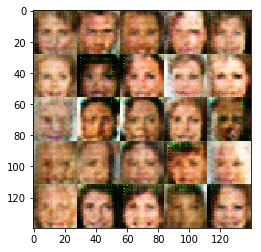

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6579


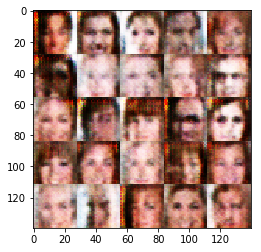

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7082


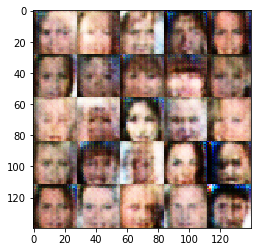

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7061


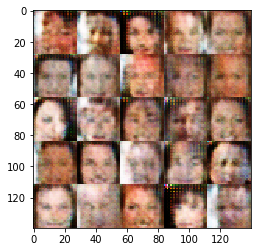

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6601


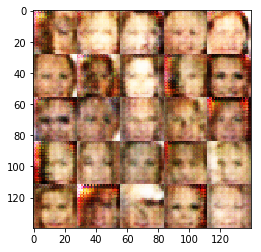

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6806


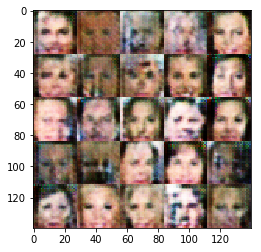

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6700


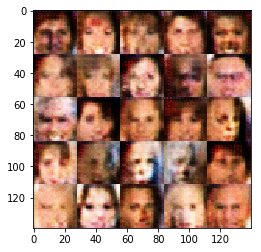

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7179


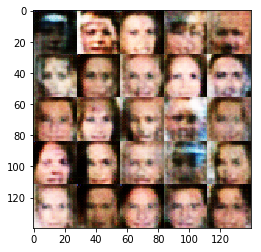

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6787


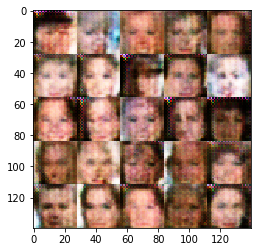

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6823


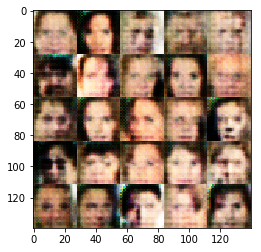

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6742


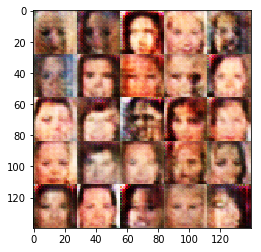

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6895


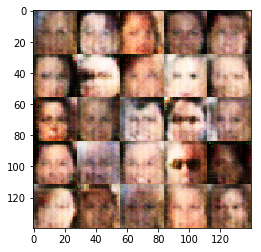

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6800


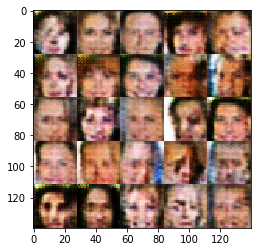

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6845


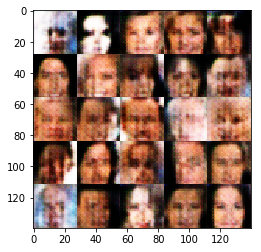

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6869


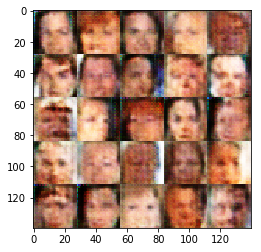

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6773


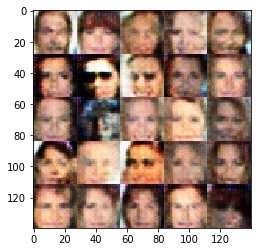

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6669


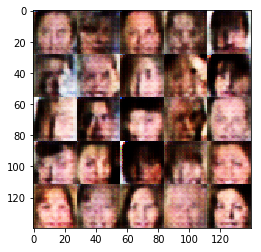

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6691


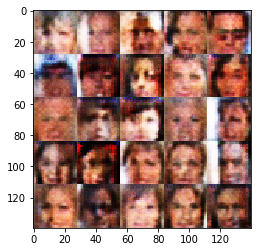

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6689


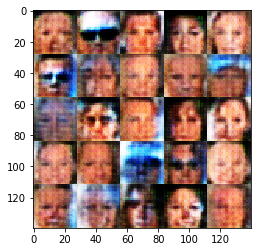

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6780


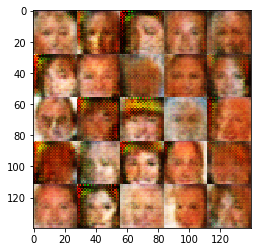

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6986


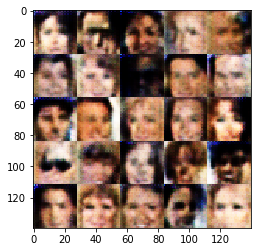

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6850


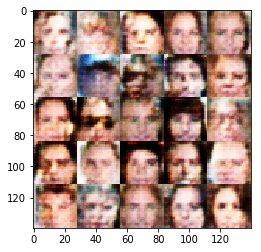

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6750


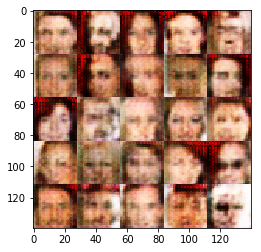

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6903


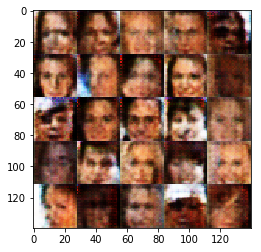

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7146


In [16]:
#batch_size = 32
batch_size = 32
z_dim = 100
learning_rate = 0.0008
#learning_rate = 0.0001, 0.0008, 0.002
beta1 = 0.4
#beta1 = 0.2, 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.